In [1]:
from lightning.pytorch.loggers import TensorBoardLogger
import os
import sys

from lightning.pytorch.callbacks import StochasticWeightAveraging
import glob
import os
import lightning as L
sys.path.insert(0, "/home/tordjx/DATA_DIR/config/projects/TRANSFERABLECLEANDATAPOISONING/lib/python/")
from customlib.dataloaders import CustomDataset
data_dir = 'path to your dataset'
import timm
import numpy as np
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt
import torchmetrics
import torch
torch.manual_seed(0)
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from monai.networks.nets import UNet,BasicUNetPlusPlus


In [ ]:
from monai.networks.nets import UNet,BasicUNetPlusPlus

class Generator(L.LightningModule):
    def __init__(self) : 
        super().__init__()
        # The commented out model is a U-Net, a type of convolutional neural network (CNN) for image segmentation
        # It has 2 spatial dimensions, 3 input channels, 3 output channels, and uses strides of 2
        # It also has 3 residual units per layer
        """self.model = UNet(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                channels=(4, 8, 16,32),
                strides=(2, 2,2),
                num_res_units=3)"""
        # The model being used is a Basic U-Net++, a variant of U-Net with more connections between layers
        # It also has 2 spatial dimensions, 3 input channels, and 3 output channels
        self.model = BasicUNetPlusPlus(spatial_dims =2, in_channels = 3, out_channels = 3)

    def forward(self,x) : 
        # The forward function simply passes the input through the model
        return self.model(x)[0]

    def generate_poisons(self, path = "/home/tordjx/DATA_DIR/managed_folders/TRANSFERABLECLEANDATAPOISONING/BqfvFGr8") : 
        # This function generates poisoned images and saves them to a specified path
        # First, it removes any existing files in the path
        files = glob.glob(os.path.join(path,"*"))
        for f in files:
            os.remove(f)
        # It then creates a DataLoader for the training dataset, which also returns the names of the images
        train_dataset_names = CustomDataset(data_dir, train=True, return_names = True)
        train_loader_names = DataLoader(train_dataset_names, batch_size=batch_size, shuffle=True, num_workers = 19)
        # It generates a specified number of poisoned images
        n = 5000 //batch_size
        for x,y , names in train_loader_names : 
            # For each batch of images, it generates a perturbation using the model
            with torch.no_grad():
                perturb  = self.forward(image.cuda())
                perturb = perturb.cpu()
            # It then adds the perturbation to each image and saves the result
            for i in range(x.shape[0]):
                poisonned = (image[i]+perturb[i]).numpy()
                np.save(os.path.join(os.path.join(path),names[i].replace("ppm","npy")),poisonned)

In [ ]:
# Create data sets
train_dataset = CustomDataset(data_dir, train=True, poison_dir = "link to poison dir")
test_dataset = CustomDataset(data_dir, train=False)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 19  )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 19)


In [ ]:
class Decoder(L.LightningModule):
    def __init__(self,encoders, intermediate_size = 128, nclasses= 43):
        super().__init__()
        # Get the feature sizes of each encoder
        feature_sizes = [(encoder(torch.rand(2,3,128,128))).shape[-1] for encoder in encoders ] 
        # Remove duplicate feature sizes
        feature_sizes = list(set(feature_sizes))
        # Create a dictionary mapping each feature size to an index
        self.feature_sizes_dict = dict(zip(feature_sizes , [i for i in range(len(feature_sizes))]))
        # Create a list of intermediate layers, one for each feature size
        self.intermediate_layers = nn.ModuleList([nn.Linear(f_size, intermediate_size) for f_size in feature_sizes])
        # Create a classification head layer
        self.classif_head = nn.Linear(intermediate_size, nclasses)
        # Create a layer for fake detection
        self.fake_detectors = nn.Linear(intermediate_size, 2)

    def forward(self,x) : 
        # Pass the input through the corresponding intermediate layer
        x = nn.functional.relu(self.intermediate_layers[self.feature_sizes_dict[x.shape[-1]]](x))
        # Pass the input through the classification head layer
        x = nn.functional.relu(self.classif_head(x))
        return x

    def detect_fake(self,x) :
        # Pass the input through the corresponding intermediate layer
        x = nn.functional.relu(self.intermediate_layers[self.feature_sizes_dict[x.shape[-1]]](x))
        # Pass the input through the fake detection layer
        x = nn.functional.relu(self.fake_detectors(x))
        return x

class Discriminator(L.LightningModule):
    def __init__(self,encoder_names ,decoder_size = 128, nclasses=43, encoder_freeze = True):
        super().__init__()
        # Create a list of encoders from the given names
        self.encoders = nn.ModuleList([
            timm.create_model(encoder_name, num_classes = 0 , pretrained = True) for encoder_name in encoder_names
        ])
        # If encoder_freeze is true, then the parameters of the encoders will not be updated during training
        if encoder_freeze : 
            for param in self.encoders.parameters():
                param.requires_grad = False
        # Create a decoder
        self.decoder  = Decoder(self.encoders)

    def forward(self,x):
        # Pass the input through each encoder to get the embeddings
        embeddings = [encoder(x) for encoder in self.encoders]
        # Pass each embedding through the decoder and stack the results
        return torch.stack([self.decoder(emb) for emb in embeddings]),torch.stack([self.decoder.detect_fake(emb) for emb in embeddings])

In [3]:
from monai.networks.nets import UNet,BasicUNetPlusPlus

class Generator(L.LightningModule):
    def __init__(self) : 
        super().__init__()
        # The commented out model is a U-Net, a type of convolutional neural network (CNN) for image segmentation
        # It has 2 spatial dimensions, 3 input channels, 3 output channels, and uses strides of 2
        # It also has 3 residual units per layer
        """self.model = UNet(
                spatial_dims=2,
                in_channels=3,
                out_channels=3,
                channels=(4, 8, 16,32),
                strides=(2, 2,2),
                num_res_units=3)"""
        # The model being used is a Basic U-Net++, a variant of U-Net with more connections between layers
        # It also has 2 spatial dimensions, 3 input channels, and 3 output channels
        self.model = BasicUNetPlusPlus(spatial_dims =2, in_channels = 3, out_channels = 3)

    def forward(self,x) : 
        # The forward function simply passes the input through the model
        return self.model(x)[0]

    def generate_poisons(self, path = "path to the dataset") : 
        # This function generates poisoned images and saves them to a specified path
        # First, it removes any existing files in the path
        files = glob.glob(os.path.join(path,"*"))
        for f in files:
            os.remove(f)
        # It then creates a DataLoader for the training dataset, which also returns the names of the images
        train_dataset_names = CustomDataset(data_dir, train=True, return_names = True)
        train_loader_names = DataLoader(train_dataset_names, batch_size=batch_size, shuffle=True, num_workers = 19)
        # It generates a specified number of poisoned images
        n = 5000 //batch_size
        for x,y , names in train_loader_names : 
            # For each batch of images, it generates a perturbation using the model
            with torch.no_grad():
                perturb  = self.forward(image.cuda())
                perturb = perturb.cpu()
            # It then adds the perturbation to each image and saves the result
            for i in range(x.shape[0]):
                poisonned = (image[i]+perturb[i]).numpy()
                np.save(os.path.join(os.path.join(path),names[i].replace("ppm","npy")),poisonned)

2024-01-06 12:23:42.694735: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-06 12:23:42.695969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 12:23:42.713109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 12:23:42.713126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 12:23:42.713138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [ ]:
class GAN(L.LightningModule):
    def __init__(self,generator, discriminator,train_dataloader, val_dataloader,lr = 5e-4, alpha = 0):
        super().__init__()
        # Initialize the generator and discriminator, along with the dataloaders for training and validation
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.generator = generator
        self.discriminator = discriminator
        # Use cross entropy loss as the criterion for training
        self.criterion = nn.CrossEntropyLoss()
        # Set the learning rate and alpha, which is used for L2 regularization
        self.lr = lr
        self.alpha = alpha
        # Disable automatic optimization, as we will be manually performing the optimization steps
        self.automatic_optimization = False

    def training_step(self,batch,batch_idx):
        x,y = batch
        optimizer_g, optimizer_d = self.optimizers()
        
        ##DISCRIMINATOR STEP
        # Generate a perturbation using the generator
        with torch.no_grad():
            perturbation = self.generator(x)
        # Add the perturbation to the input images to create poisoned images
        poisonned_image = perturbation + x
        # Pass the poisoned images through the discriminator to get the predictions and the predicted fakeness
        predictions, predicted_fakeness = self.discriminator(poisonned_image)
        # The fakeness is set to 1, as these images are fake
        fakeness = torch.ones_like(y).cuda()
        # Calculate the loss for the poisoned images
        discriminator_loss_poisoned = torch.mean(torch.stack([self.criterion(pred,y) for pred in predictions]))
        discriminator_loss_poisoned =discriminator_loss_poisoned+ torch.mean(torch.stack([self.criterion(pred,fakeness) for pred in predicted_fakeness]))
        # Pass the real images through the discriminator to get the predictions and the predicted fakeness
        predictions, predicted_fakeness= self.discriminator(x)
        # The fakeness is set to 0, as these images are real
        fakeness = torch.zeros_like(y).cuda()
        # Calculate the loss for the real images
        discriminator_loss_real = torch.mean(torch.stack([self.criterion(pred,y) for pred in predictions]))
        discriminator_loss_real =discriminator_loss_real+ torch.mean(torch.stack([self.criterion(pred,fakeness) for pred in predicted_fakeness]))
        # The total discriminator loss is the sum of the losses for the real and poisoned images
        discriminator_loss = discriminator_loss_poisoned+discriminator_loss_real
        # Perform the optimization step for the discriminator
        optimizer_d.zero_grad()
        self.manual_backward(discriminator_loss)
        optimizer_d.step()
        # Log the losses
        self.log("discriminator_loss_real", discriminator_loss_real)
        self.log("discriminator_loss_poisoned", discriminator_loss_poisoned)
        self.log("discriminator_loss", discriminator_loss)
        ##GENERATOR STEP
        # Generate a perturbation using the generator
        perturbation = self.generator(x)
        # Add the perturbation to the input images to create poisoned images
        poisonned_image = perturbation + x
        # Disable gradient calculation for the decoder parameters of the discriminator
        for param in self.discriminator.decoder.parameters():
            param.requires_grad = False
        # Pass the poisoned images through the discriminator to get the predictions and the predicted fakeness
        predictions , predicted_fakeness= self.discriminator(poisonned_image)
        # The fakeness is set to 1, as these images are fake
        fakeness = torch.ones_like(y).cuda()
        # Calculate the loss for the generator
        discriminator_loss = torch.mean(torch.stack([self.criterion(pred,y) for pred in predictions]))
        fake_detector_loss_gen = torch.mean(torch.stack([self.criterion(pred,fakeness) for pred in predicted_fakeness]))
        discriminator_loss =discriminator_loss + fake_detector_loss_gen
        # Add an L2 penalty to the loss
        L2_pen = nn.MSELoss()(perturbation, torch.zeros_like(perturbation))
        generator_loss = - discriminator_loss + self.alpha *L2_pen 
        # Enable gradient calculation for the decoder parameters of the discriminator
        for param in self.discriminator.decoder.parameters():
            param.requires_grad = True
        # Perform the optimization step for the generator
        optimizer_g.zero_grad()
        self.manual_backward(generator_loss, retain_graph = True)
        optimizer_g.step()
        # Log the losses and the L2 penalty
        self.log("alpha*L2_pen", self.alpha*L2_pen)
        self.log("generator_loss", generator_loss)
        self.log("fake_detector_loss_gen", fake_detector_loss_gen)

In [5]:
# Set the environment variable for the TensorBoard binary to the specified path
os.environ["TENSORBOARD_BINARY"]="/home/tordjx/DATA_DIR/code-envs/python/rapids/bin/tensorboard"

# Reload the TensorBoard extension to ensure it's using the latest version
%reload_ext tensorboard

# Start TensorBoard with the specified log directory
%tensorboard --logdir=lightning_logs/

# Set the name for the logs
log_name = "sans L2"

# Create a TensorBoard logger with the specified log directory and name
logger = TensorBoardLogger("lightning_logs/", name=log_name)

# Create a PyTorch Lightning trainer with one device, a maximum of 15 epochs, and the specified logger
trainer = L.Trainer(devices = 1,max_epochs=15, logger = logger)

# Specify the names of the encoders to be used in the discriminator
encoder_names = ['resnet34' , "resnest26d","efficientnet_b0","resnext50_32x4d","regnetx_006","densenet121"]

# Create a generator
generator = Generator()

# Create a discriminator with the specified encoders
discriminator = Discriminator(encoder_names)

# Create a GAN with the generator, discriminator, and the training and testing dataloaders
gan = GAN(generator, discriminator, train_loader, test_loader)

# Train the GAN with the training and testing dataloaders
trainer.fit(gan, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).


/home/tordjx/DATA_DIR/code-envs/python/rapids/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
Missing logger folder: lightning_logs/sans L2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params
---------------------------------------------------
0 | generator     | Generator        | 2.4 M 
1 | discriminator | Discriminator    | 76.6 M
2 | criterion     | CrossEntropyLoss | 0     
---------------------------------------------------
3.1 M     Trainable params
75.9 M    Non-trainable params
79.0 M    Total params
316.084   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Process Process-252:
Process Process-255:
Process Process-254:
Process Process-256:
Process Process-253:
Process Process-251:
Process Process-257:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 360, in _e

In [7]:
# fit the model
trainer.fit(gan, train_loader, test_loader)

/home/tordjx/DATA_DIR/code-envs/python/rapids/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory lightning_logs/sans L2/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params
---------------------------------------------------
0 | generator     | Generator        | 2.4 M 
1 | discriminator | Discriminator    | 76.6 M
2 | criterion     | CrossEntropyLoss | 0     
---------------------------------------------------
3.1 M     Trainable params
75.9 M    Non-trainable params
79.0 M    Total params
316.084   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/tordjx/DATA_DIR/code-envs/python/rapids/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [2]:

os.environ["TENSORBOARD_BINARY"]="/home/tordjx/DATA_DIR/code-envs/python/rapids/bin/tensorboard"
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


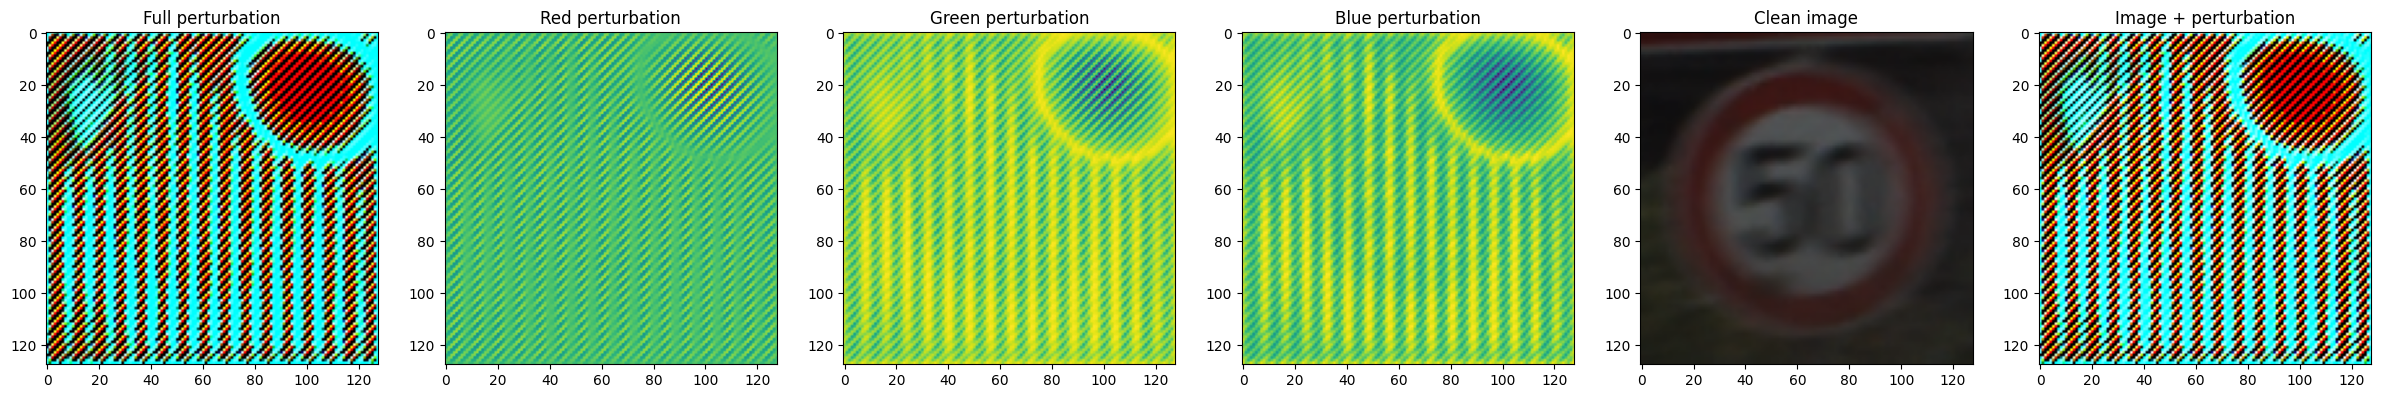

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


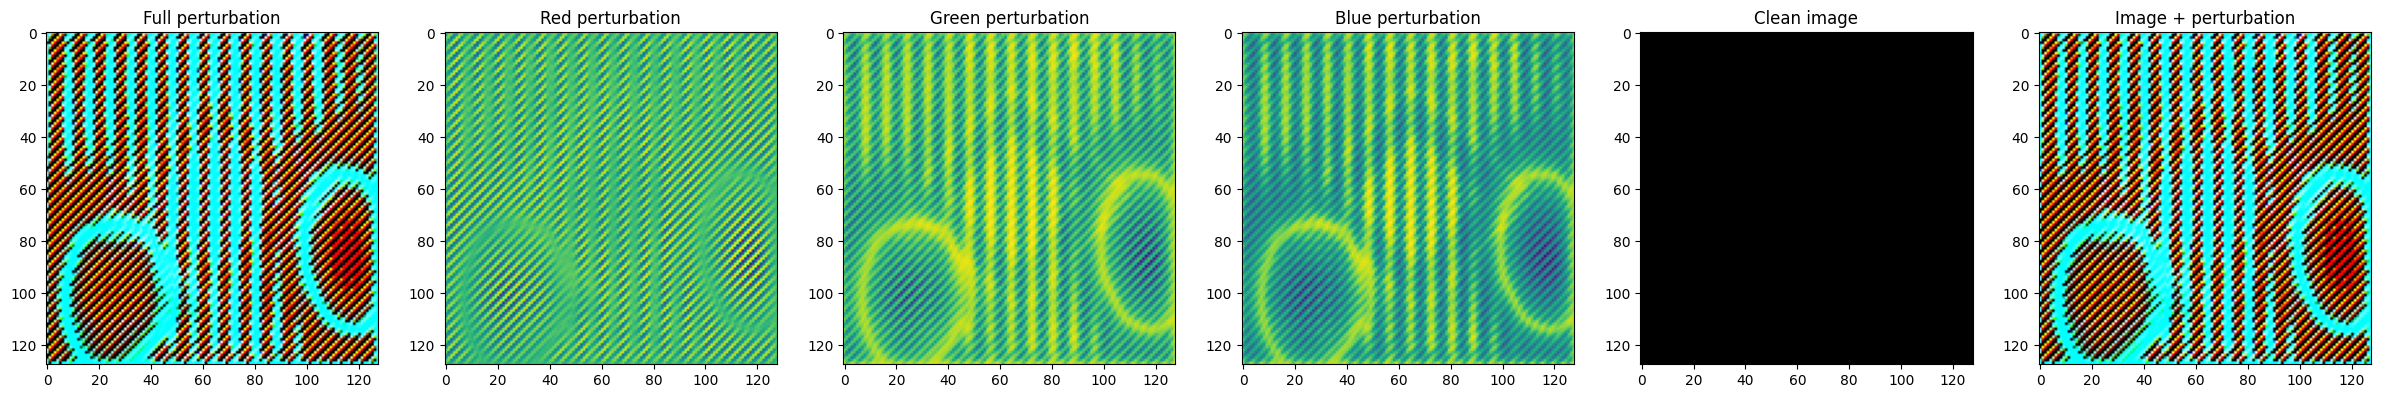

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


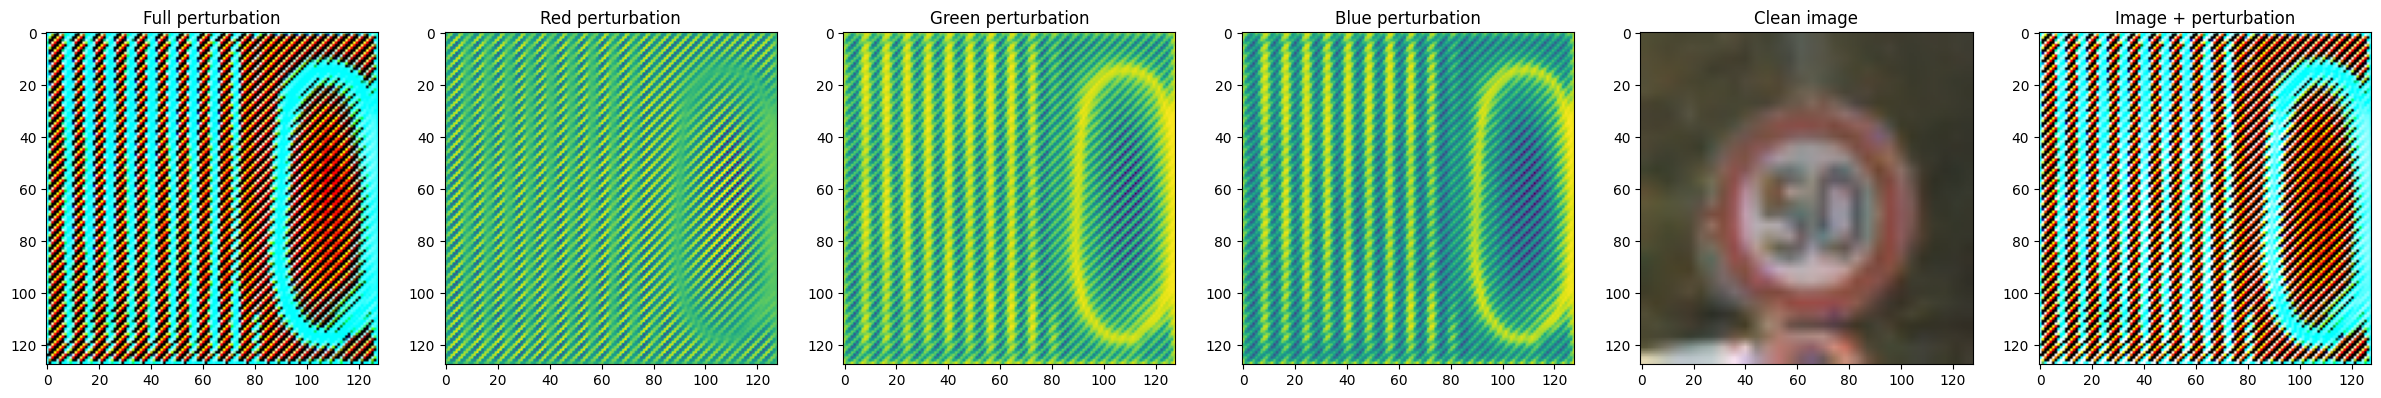

In [6]:
# Simulation with real images
image,y = next(iter(train_loader))
with torch.no_grad() : 
    perturb = gan.generator.cuda()(image.cuda()).cpu() 

for idx in range(3):
    
    fig, ax = plt.subplots(1,6, figsize = (30,5))
    ax[0].imshow(perturb[idx].moveaxis(0,-1))
    ax[0].set_title("Full perturbation")
    ax[1].imshow(perturb[idx][0])
    ax[1].set_title("Red perturbation")
    ax[2].imshow(perturb[idx][1])
    ax[2].set_title("Green perturbation")
    ax[3].imshow(perturb[idx][2])
    ax[3].set_title("Blue perturbation")
    ax[4].imshow(image[idx].moveaxis(0,-1))
    ax[4].set_title("Clean image")
    ax[5].imshow(perturb[idx].moveaxis(0,-1)+image[idx].moveaxis(0,-1))
    ax[5].set_title("Image + perturbation")
    plt.show()
